<a href="https://colab.research.google.com/github/m5532m5532/2D/blob/main/Detectron2_Tutorial_20200607_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! In this tutorial, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial or use "File -> Open in playground mode" to play with it yourself.


# Install detectron2

In [1]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
#import torch, torchvision
#torch.__version__
#!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.0MB 56.8MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0+cu100 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 276kB 34.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=9ec2b13bd2410c2e3afb2f79583fe39571c9c103905e9227826d12790ff694a8
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
  

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.7MB 634kB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=263980 sha256=8aef4d88db2d44f6b02a6d4573e7446524ac3446b70e24c697f38b10e2f1aea9
  Stored in directory: /root/.cache/pip/wheels/68/a5/e7/56401832f23d0b2db351c5b682e466cb4841960b086da65e4e
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210604-cp37-none-any.whl size=60475 sha256=501ee76d2abffc187cf6a6038c7b7e926cc7f51571f43e2f169d7de25f776111
  Stored in directory: /root/.cache/pip/wheels/74/e3/fb/2d4b0c12020f6e4535c2a8fb2da9b6b17cf9f03efd4e542ffc
Successfully built pycocotools fvcore
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

In [4]:
detectron2?

# Run a pre-trained detectron2 model

We first download a random image from the COCO dataset:

--2021-06-05 12:37:30--  http://images.cocodataset.org/val2017/000000439715.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.100.115
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.100.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209222 (204K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 204.32K  --.-KB/s    in 0.01s   

2021-06-05 12:37:30 (14.9 MB/s) - ‘input.jpg’ saved [209222/209222]



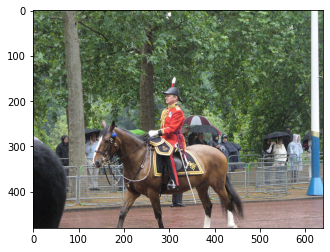

In [5]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg
im = cv2.imread("./input.jpg")
#cv2_imshow(im)
#cv2.imshow('image',im)
plt.imshow(im[:,:,::-1])

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

full-path of model zoo:

/home/ny/anaconda3/envs/detectron2/lib/python3.6/site-packages/detectron2/model_zoo



In [6]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:08, 21.2MB/s]                           


In [7]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
#outputs["instances"].pred_boxes

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')

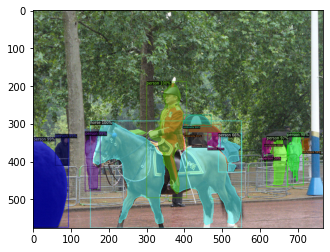

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image())
#cv2_imshow(v.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

## Prepare the dataset

### Play with my own data

From "labelme json" to "coco-formated json":
https://www.dlology.com/blog/how-to-create-custom-coco-data-set-for-instance-segmentation/

Load "coco-formated json" to make a "list of dictionaries":
https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/

In [9]:
MetadataCatalog.list()

['coco_2014_train',
 'coco_2014_val',
 'coco_2014_minival',
 'coco_2014_minival_100',
 'coco_2014_valminusminival',
 'coco_2017_train',
 'coco_2017_val',
 'coco_2017_test',
 'coco_2017_test-dev',
 'coco_2017_val_100',
 'keypoints_coco_2014_train',
 'keypoints_coco_2014_val',
 'keypoints_coco_2014_minival',
 'keypoints_coco_2014_valminusminival',
 'keypoints_coco_2014_minival_100',
 'keypoints_coco_2017_train',
 'keypoints_coco_2017_val',
 'keypoints_coco_2017_val_100',
 'coco_2017_train_panoptic_separated',
 'coco_2017_train_panoptic_stuffonly',
 'coco_2017_val_panoptic_separated',
 'coco_2017_val_panoptic_stuffonly',
 'coco_2017_val_100_panoptic_separated',
 'coco_2017_val_100_panoptic_stuffonly',
 'lvis_v1_train',
 'lvis_v1_val',
 'lvis_v1_test_dev',
 'lvis_v1_test_challenge',
 'lvis_v0.5_train',
 'lvis_v0.5_val',
 'lvis_v0.5_val_rand_100',
 'lvis_v0.5_test',
 'lvis_v0.5_train_cocofied',
 'lvis_v0.5_val_cocofied',
 'cityscapes_fine_instance_seg_train',
 'cityscapes_fine_sem_seg_train

In [ ]:
#MetadataCatalog.get(name).set()

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
%cd /content/gdrive/My Drive/Test_Detectron2
!ls

/content/gdrive/.shortcut-targets-by-id/1ZJ-NnAyj4LsRNbyGsagzRrJNpGwiea7b/test_detectron2
'=2.0.1'
 architecture.jpg
 backup
 COCO_Image_Viewer.ipynb
'custimize_datasets_ for_detectron2_training.txt'
 detectron2
 detectron2_repo
 Detectron2_Tutorial_20200607_v3.ipynb
 Detectron2_Tutorial_20200813_v6.ipynb
 eye
'eye (original)'
 face_mask
 face_mask-20200813T142403Z-001.zip
 get_dict_from_via.py
 ICCV19_Detectron2.pdf
 ICCV19_generalized_rcnn_tutorial_ross_girshick.pdf
 input.jpg
 install_detectron2_locally.txt
'Introduce Mask R-CNN.gslides'
 labelme2coco.py
'Mask R-CNN architecture.gdoc'
 output
 test_Detectron2.ipynb
 連結.pptx


In [12]:
!pip install labelme

     |████████████████████████████████| 1.5MB 29.3MB/s 
     |████████████████████████████████| 7.7MB 22.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.3MB 29.4MB/s 
     |████████████████████████████████| 317kB 58.5MB/s 
     |████████████████████████████████| 59.9MB 56kB/s 
  Created wheel for imgviz: filename=imgviz-1.2.6-cp37-none-any.whl size=7674115 sha256=13b8b8dd32141f7e30275f105882439cd9f3ccd57b676924e858e5e4105fb466
  Stored in directory: /root/.cache/pip/wheels/ba/52/63/39807618049f08b3531bdc8ca17dfed5fff0cd2fa282bf5b32
Successfully built imgviz
  Created wheel for labelme: filename=labelme-4.5.7-cp37-none-any.whl size=1464747 sha256=b867639f6f0587066cacc150a1f8443958adfadd20f37ec92f24e7128cfd74a2
  Stored in directory: /root/.cache/pip/wheels/d6/22/00/b8c0b3a9f1ea35f50dd9e51acdde9ffa73d976adffe1292731
Successfully built labelme


In [13]:
!python labelme2coco.py labelme_images='/content/gdrive/My Drive/Test_Detectron2/eye/train/'

labelme_images=/content/gdrive/My Drive/Test_Detectron2/eye/train/
[]
save coco json
trainval.json


In [14]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("eye_train", {}, "./eye/train/train.json", "./eye/train")
register_coco_instances("eye_val", {}, "./eye/val/val.json", "./eye/val")

#from detectron2.data import DatasetCatalog, MetadataCatalog
#for d in ["train", "val"]:
#    DatasetCatalog.register("eye_" + d, lambda d=d: load_coco_json("eye/train/{}.json".format(d), "eye/()".format(d)))
#    MetadataCatalog.get("eye_" + d).set(thing_classes=["eye"])
eye_metadata = MetadataCatalog.get("eye_train")

How to clear the registered dataset?
https://github.com/facebookresearch/detectron2/blob/master/detectron2/data/catalog.py

In [ ]:
#print(type(DatasetCatalog._REGISTERED)   )
#DatasetCatalog._REGISTERED.keys()
#del DatasetCatalog._REGISTERED['eye_train']

In [15]:
eye_metadata

Metadata(evaluator_type='coco', image_root='./eye/train', json_file='./eye/train/train.json', name='eye_train')

In [16]:
from detectron2.data.datasets.coco import load_coco_json

[06/05 12:39:13 d2.data.datasets.coco]: Loaded 3 images in COCO format from eye/train/train.json


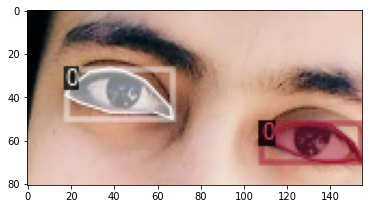

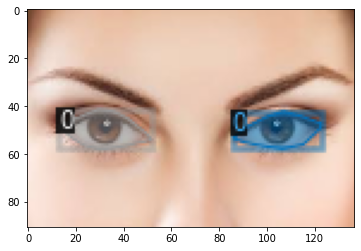

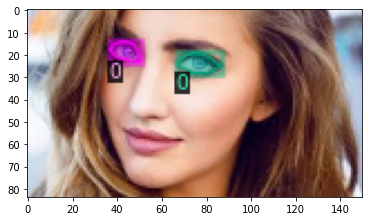

In [17]:
eye_dicts = load_coco_json("eye/train/train.json", "eye/train")
for d in eye_dicts:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=eye_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    #cv2_imshow(vis.get_image()[:, :, ::-1])
    plt.imshow(vis.get_image())
    plt.show()

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [18]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("eye_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4  ## = 2  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/05 12:39:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[06/05 12:39:23 d2.engine.train_loop]: Starting training from iteration 0
[06/05 12:39:28 d2.utils.events]:  eta: 0:04:03  iter: 19  total_loss: 2.048  loss_cls: 0.645  loss_box_reg: 0.704  loss_mask: 0.689  loss_rpn_cls: 0.016  loss_rpn_loc: 0.010  time: 0.2448  data_time: 0.0150  lr: 0.000005  max_mem: 1736M
[06/05 12:39:33 d2.utils.events]:  eta: 0:03:58  iter: 39  total_loss: 2.023  loss_cls: 0.584  loss_box_reg: 0.701  loss_mask: 0.682  loss_rpn_cls: 0.012  loss_rpn_loc: 0.008  time: 0.2454  data_time: 0.0023  lr: 0.000010  max_mem: 1779M
[06/05 12:39:38 d2.utils.events]:  eta: 0:03:52  iter: 59  total_loss: 1.959  loss_cls: 0.511  loss_box_reg: 0.769  loss_mask: 0.666  loss_rpn_cls: 0.012  loss_rpn_loc: 0.009  time: 0.2461  data_time: 0.0023  lr: 0.000015  max_mem: 1779M
[06/05 12:39:43 d2.utils.events]:  eta: 0:03:49  iter: 79  total_loss: 1.841  loss_cls: 0.442  loss_box_reg: 0.755  loss_mask: 0.644  loss_rpn_cls: 0.004  loss_rpn_loc: 0.010  time: 0.2478  data_time: 0.0023  lr:

In [19]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output_eye

Launching TensorBoard...

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-f22250c76370>", line 3, in <module>
    get_ipython().magic('tensorboard --logdir output_eye')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/notebook.py", line 117, in _start_magic
    return start(line)
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/notebook.py", line 152, in start
    start_result = manager.start(parsed_args)
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/manager.py", line 401, in start
    working_directory=os.getcwd()

FileNotFoundError: ignored

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("eye_val", )
predictor = DefaultPredictor(cfg)

[06/05 12:44:32 d2.data.datasets.coco]: Loaded 3 images in COCO format from ./eye/train/train.json


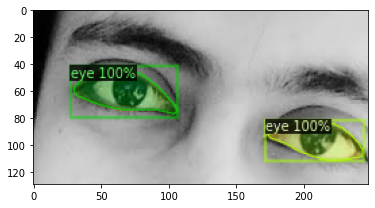

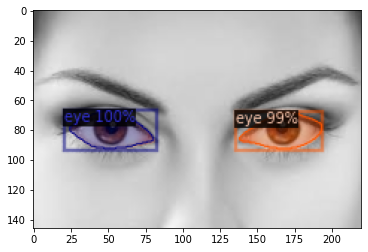

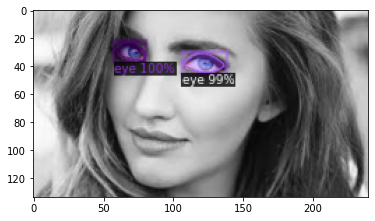

In [21]:
from detectron2.utils.visualizer import ColorMode
eye_val_dicts = load_coco_json("./eye/train/train.json", "eye/train")
for d in eye_val_dicts: 
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=eye_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2_imshow(v.get_image()[:, :, ::-1])
    plt.imshow(v.get_image())
    plt.show()

In [22]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("eye_train", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "eye_train")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [06/05 12:44:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/05 12:44:38 d2.data.datasets.coco]: Loaded 3 images in COCO format from ./eye/train/train.json
[06/05 12:44:38 d2.data.common]: Serializing 3 elements to byte tensors and concatenating them all ...
[06/05 12:44:38 d2.data.common]: Serialized dataset takes 0.00 MiB
[06/05 12:44:38 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/05 12:44:38 d2.evaluation.evaluator]: Start inference on 3 images
[06/05 12:44:39 d2.evaluation.evaluator]: Total inference time: 0:00:00.220120 (0.220120 s / img per device, on 1 devices)
[06/05 12:44:39 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.123624 s / img per device, on 1 devices)
[06/05 12:44:39 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/05 12:44:39 d2.eval

OrderedDict([('bbox',
              {'AP': 97.77227722772277,
               'AP50': 100.0,
               'AP75': 100.0,
               'APl': nan,
               'APm': 97.52475247524752,
               'APs': 100.0}),
             ('segm',
              {'AP': 97.77227722772277,
               'AP50': 100.0,
               'AP75': 100.0,
               'APl': nan,
               'APm': 97.52475247524752,
               'APs': 100.0})])

# Other types of builtin models

model_final_a6e10b.pkl: 237MB [00:11, 21.4MB/s]                           


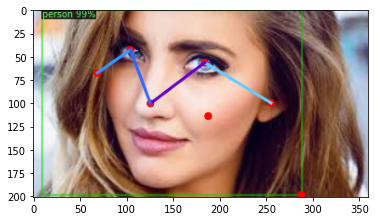

In [23]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#cv2_imshow(v.get_image()[:, :, ::-1])
plt.imshow(v.get_image())
plt.show()

model_final_cafdb1.pkl: 261MB [00:11, 22.4MB/s]                           


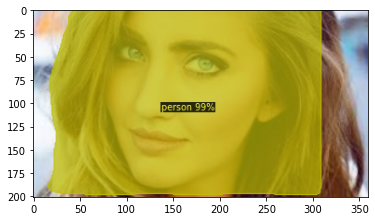

In [24]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
#cv2_imshow(v.get_image()[:, :, ::-1])
plt.imshow(v.get_image())
plt.show()

# Run panoptic segmentation on a video

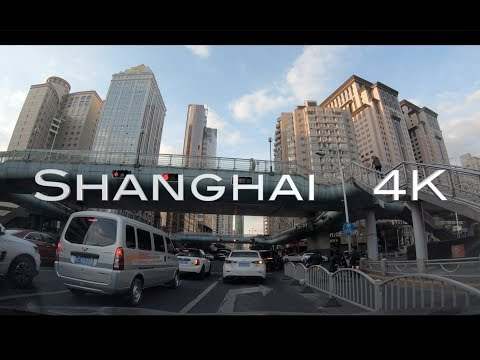

In [37]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [38]:
# Install dependencies, download the video, and crop 5 seconds for processing
#!pip install youtube-dl
#!pip uninstall -y opencv-python opencv-contrib-python
#!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/bin/bash: youtube-dl: command not found
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enab

In [33]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset
#!git clone https://github.com/facebookresearch/detectron2
#!detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
#  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl
!python /home/ny/detectron2_uninstalled/demo/demo.py --config-file /home/ny/detectron2_uninstalled/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml \
  --video-input video-clip.mp4 --confidence-threshold 0.6 --output /home/ny/Codes/detectron2/video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl
    

python3: can't open file '/home/ny/detectron2_uninstalled/demo/demo.py': [Errno 2] No such file or directory


In [34]:
# Download the results
from google.colab import files
files.download('video-output.mkv')

FileNotFoundError: ignored